# 自己組織化マップとクラスタリングによるデータ分析

## 注意１

まず、レポート課題に添付されたサンプルデータを使って、SOMとK-means法を使ったデータ解析法を理解してください。これはあくまでも練習です。サンプルデータについては、クラスタ分割の結果（画像）だけ報告してください。分析は不用です。

<font color=red size=4>メインの課題は、自分で解析のテーマを設定し、自分で用意したデータデータ分析することです。</font>


## 注意２
Google Colaboratory 用のプログラムファイルです。Chrome以外のブラウザでは不具合が発生する可能性があります。（新EdgeはChromeエンジンなのでたぶん大丈夫)
 
**（準備）**

<img width="350" alt="upload" src="https://user-images.githubusercontent.com/5820803/93283416-75a07480-f80b-11ea-8bda-16f31849433f.png">

左のファイルツリーのエリアに、**jinkoSJ.csv** と **kendata.csv** をアップロードし、プログラムのセルを実行していってください。

<font color=red>自分で作ったデータで実行する場合は、そのファイルをアップロードし、プログラム中の jinkoSJ.csv という部分を自分のデータのファイル名に書き換えて実行してください。もしくは、ファイル名の方を合わせてもかまいません。</font>

In [ ]:
!pip install japanize-matplotlib

# 自己組織化マップ（SOM)＆クラスタリング

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib # <- Windows の場合、この行の先頭に # を入力してコメントアウト
# %matplotlib inline
# import PIL.Image
# import cv2

# 都道府県データの自己組織化マップ

[都道府県データランキング](http://uub.jp/pdr/)

上のデータランキングのデータを適当に組合せて、kendata.csv というデータを作成した。ここでは説明のために、さらに人口、面積、人口密度の３つの項目だけを抜き出したデータ、<font color='red'>jinkoSJ.csv</font> を使ってプログラムの一連の流れを説明する。 生データは一番下にしてある。各自が試す場合は項目は３つではなくもっとたくさん用いよ。


# １．データの読み込み

In [ ]:
data = pd.read_csv("jinkoSJ.csv", delimiter=",", encoding="cp932")  # Windows版 Excel の csv ファイルの場合
#data = pd.read_csv("kendata.csv", delimiter=",", encoding="utf-8")  # Unicodeの場合　(macOS,Linux はUnicode)
data.head() # 上から５データ分表示

,都道府県,人口,面積,人口密度
0,東京都,13636222,2191.00,6223.74
1,神奈川県,9145572,2415.92,3785.54
2,大阪府,8837812,1905.14,4638.93
3,愛知県,7507691,5172.90,1451.35
4,埼玉県,7288081,3797.75,1919.05


## (解説)
１行目　　Excel ファイルを読み込んで、 data というpandas配列に格納。（※）  
３行目　　head() は先頭から５つ分を取り出す関数。読み込みが成功しているかどうかの確認

<font size=2 color='red'> ※　自分でExcelデータを作る場合、データに日本語（全角文字）が含まれているときは、漢字コードに注意が必要です。Windows のExcel はShiftJISコード(cp932)がデフォルト、それ以外のOSはUnicodeとなっています。このサンプルプログラムでは、大多数の人が使うであろうWindows を前提にしています。</font>

# サンプルデータ（人口、面積、人口密度）
読み込んだデータは、都道府県別の「人口、面積、人口密度」のデータである。

このデータを用いて、自己組織化マップSOMを用いたデータ分析の例を示そう。

SOMの解析では、都道府県名の欄をカットした数値部分のデータのみを用いる。これを　X　という配列として抽出する。


In [ ]:
dataindex = data.columns[1:] # ２列目以降のカラムインデックス
pref = data['都道府県'] # 都道府県名のリスト（１列目だけ取り出して pref に代入）
X = data[dataindex] # ２列目以降を抜き出してXとする。これがSOMの処理対象
X.head()

,人口,面積,人口密度
0,13636222,2191.00,6223.74
1,9145572,2415.92,3785.54
2,8837812,1905.14,4638.93
3,7507691,5172.90,1451.35
4,7288081,3797.75,1919.05


# ２．標準化
データ X は項目ごとにデータの粒度が違うので**標準化**、もしくは**正規化**して使う。

**「標準化」**とは、与えられたデータを平均値が０、標準偏差が１となるように線形変換することである。また、**「正規化」**とは、与えられたデータをちょうど０～１の範囲に収まるように線形変換することをいう。

Pythonには標準化や正規化のためのクラスライブラリが用意されているので、簡単に標準化、正規化が実行できる。

ここでは**標準化**を用いることにする。

## 標準化

In [ ]:
from sklearn.preprocessing import StandardScaler # 標準化のライブラリ
sc = StandardScaler() # 標準化作用素の生成
stdX = sc.fit_transform(X) # 標準化の実行
#  stdX には X が標準化されたデータが格納される。この操作で pandas dataframe から 普通の numpy 配列に変わる。

stdX[0:5] # 上から５つ表示

array([[ 4.02824661, -0.52808322,  4.68663368],
       [ 2.37395522, -0.50740667,  2.63428102],
       [ 2.26058083, -0.5543619 ,  3.35262129],
       [ 1.77058323, -0.25396163,  0.6694787 ],
       [ 1.68968204, -0.38037711,  1.06316475]])

# ３．SOM のメソッドを定義

In [ ]:
import scipy.stats as st
# ガウス分布
def gkern(kernlen=21, nsig=3):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

# 自己組織化マップ SOM を生成する　　　　M :２次元配置されたニューロンの重み配列    x : 入力データ,  alpha：学習係数
def organize_som(M, x, alpha=0.3, ksize=3):
    gk = gkern(2*ksize+1,ksize)/np.max(gkern(2*ksize+1,ksize))
    mini, minj = get_winner(M,x) # マップMに配置されたニューロンの中で、その重みがもっとも x に近いニューロンの座標
    dim = x.shape[0] # 入力の次数
    # Mよりも上下左右にksize分広げた作業用マップを準備
    MM = np.zeros((M.shape[0]+2*ksize, M.shape[1]+2*ksize,dim),np.float64)
    MM[ksize:-ksize,ksize:-ksize]=M
    #  勝者の近傍（ksize=3 なら7x7）の範囲を与えられたデータに近づける
    for i in range(-ksize,ksize+1): 
        for j in range(-ksize,ksize+1):
            try:
                MM[ksize+mini+i,ksize+minj+j] += alpha * (x - MM[ksize+mini+i,ksize+minj+j])*gk[ksize+i,ksize+j]
            except:
                pass
    return MM[ksize:-ksize,ksize:-ksize]

# 境界の描画
def plotBoundary(labels, somcenters,cmap='Pastel1'):
    row = labels.shape[0]
    col = labels.shape[1]
    
    YY,XX = np.mgrid[0:row, 0:col] # make a grid    
    
    plt.pcolormesh(XX, YY, labels, cmap=cmap,zorder=-10) 
            
    for index, p in enumerate(somcenters):
        plt.text(p[1],p[0],str(index),ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.3, lw=0))

# Map M において、ベクトルｘともっとも近い重みベクトルを持つノードの座標を得る
def get_winner(M,x):
    col =  M.shape[1]
    # row =  M.shape[0]
    min_i = np.argmin(((M-x)**2).sum(axis=2)) 
    mini = min_i // col # argmin は1次元化した番号が返ってくるので　2次元化
    minj = min_i % col
    return mini, minj


# ４．SOMのメインプログラム

In [ ]:
# メインプログラム
row = 20  # マップの高さ
col = 30 # マップの幅
learntime = 256# 繰り返し学習回数
alpha = 0.3 # 学習係数

W = np.random.random([row,col,len(dataindex)]) # Map 用の配列を生成し、初期の重みをランダムに設定

for time in range(learntime):
    for color in stdX:
        W=organize_som(W, color,alpha=alpha,ksize=5) # 競合学習の実行


ここでは、マップを構成する競合層ニューロンを、20ｘ30個としている。
個々のニューロンのシナプスの数は入力データの次元で決まる。サンプルデータの場合は都道府県データから３項目を取り出して使っているので入力は３次元ベクトル。よって入力層ニューロンは３個、競合層の６００個のニューロンはそれぞれ３つずつ重みデータを持つことになる。

<img width="491" alt="重み" src="https://user-images.githubusercontent.com/5820803/93285327-9074e800-f80f-11ea-807d-af44210c790d.png">

SOMフォルダにある kendata.csv には８項目からなるデータが収められている。そちらを使う場合は、各データが８次元なので、重みは８つずつとなる。シナプスの数は、20×30×８となる。計算時間は次元数やマップのサイズに比例する。

競合学習が終わると、20ｘ30＝600個の3次元データが得られる。この600個のデータをk-means法でクラスタリングし，各クラスタにカラーを割り当てて表示することにしよう．


# ５．クラスタリング
## ５．１　クラスタリングのプログラム


In [ ]:
from sklearn.cluster import KMeans

def kmeans(M,k,itr):   # 配列Mの要素を対象として k-means 法でクラスタリングを実行する　　
    row = M.shape[0]   # k クラスタ数、 itr 繰り返し処理回数
    col = M.shape[1]
    ch = M.shape[2]
    data = M.reshape(col*row,ch)
    km = KMeans(n_clusters=k,init='random',n_init=1,max_iter=itr,random_state=1)
    labelimage = (km.fit(data).labels_).reshape(row,col)
    centers = km.cluster_centers_
    return labelimage, centers 

# 都道府県名の描画
def writePref(W, pref, data, dataindex):
     for index, pname in enumerate(pref):
        d1 =  np.array(data[index])
        (y,x)= get_winner(W,d1)
        plt.text(x,y,pref.loc[index],ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.2, lw=0))   

↑このプログラムは定義だけなので実行しても何も表示されません。しかし、実行は必要です。

# 5.2　クラスタリング実験

## 5.2.1 実験前の考察

#### データについての考察
　jinkoSJ.csv というデータは、「人口」「人口密度」「面積」の３項目からなる。「人口密度」は「人口」と「面積」のデータから計算できるデータである。深いネットワークであれば階層を経ることで「人口」と「面積」だけでも、中間層ニューロンが「人口密度」の役割を果させることができるので「人口密度」は不要かもしれないが、今回用いるニューラルネットワークは入力層が直接競合層と結びつけられた基本的な構成なので、「人口密度」のデータがなければ、「人口密度」が基準となるようなクラスタは発生しないであろう。
 
#### クラスタ数ごとの、生成されるクラスタの予想シナリオ

#### （１）２クラスタ
2クラスタの場合、次のようなクラスタ分割の可能性が予想される。
- （予想シナリオ１） 北海道の面積が突出しているので、北海道とそれ以外というクラスタ分割が行われる。
- （予想シナリオ２）人口または人口密度基準で、東京、神奈川、大阪などの人口の密集した大都会を擁する都道府県が他と分離される

#### （２）３クラスタ
３クラスタの場合、次のようなクラスタ分割の可能性が予想される。
- （予想シナリオ１）2クラスタにおける２つの予想が組み合わさって、大都市クラスタ、北海道、その他という3クラスタが発生する。
- （予想シナリオ２）（１）超大都市圏（東京、神奈川、大阪）、（２）埼玉、神戸、愛知などの大都市圏（３）その他の地方とで3クラスタとなる。

## 5.2.2 実験
### (1) データをk-means法で２分割

In [ ]:
# 2-means
labelimage, centers = kmeans(W,2,100)
somcenters = [get_winner(W,c) for c in centers]
# plt.rcParams['font.family'] = 'HGMaruGothicMPRO'　# ← ローカルのWindowsのpythondで実行する場合
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)
plt.savefig("som2.png");

NameError: ignored

# （実験結果についての考察の例）

><img width="377" alt="dample" src="https://user-images.githubusercontent.com/5820803/93286733-da130200-f812-11ea-9eb8-b9dc7edd7a53.png">    
       　　　　　図〇〇　２クラスタ分割の結果    
 *　２クラスタ分割の結果を図〇〇に示す。結果は予想シナリオ２に近いが、東京、大阪、神奈川に加えて、愛知、埼玉が同じクラスタとなり、他の都道府県と分離される結果となった。愛知は東京圏、大阪圏につぐ中部地方の中核であり、３大都市圏が同じクラスタとしてまとめられた形である。また、埼玉県は神奈川と同じで首都圏を構成する県であるということがわかる*。






**【注意】** 結果は乱数の初期値によりさまざまに変化する。何度かやってみればいくつかのパターンが現れるので試してみるとよい。なお、やり直す場合は「４　SOMのメインプログラム」のところから、再実行する。defだけの箇所は飛ばしていい。

<img width="634" alt="result" src="https://user-images.githubusercontent.com/5820803/93287174-ce740b00-f813-11ea-9e99-e21deed09aee.png">


- シナリオ１の予想通りのケース
- シナリオ２の予想通りのケース
- シナリオ１と２が混ざり大都市に北海道が加わるケース
- 大都市クラスタに、福岡、兵庫なども加わるケース
など



# （2）データをk-means法で3分割


In [ ]:
# 3-means
labelimage, centers = kmeans(W,3,100)
somcenters = [get_winner(W,c) for c in centers]
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)
plt.savefig("som3.png");

# （実験結果についての考察の例）
結果は3クラスタにおける（予想シナリオ１）の予想通りであるといえる。

# （3）データをk-means法で5分割

In [ ]:
# 5-means
labelimage, centers = kmeans(W,5,100)
somcenters = [get_winner(W,c) for c in centers]
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)
plt.savefig("som5.png");

# （実験結果についての考察の例）

東京、大阪、神奈川という超大都市が大都市クラスタから分離し、残りの埼玉と愛知と、それらに次ぐ人口過密県である、千葉、兵庫、福岡が加わったクラスタが形成されたことがわかる。また、その他の県が２つのクラスタに分離しているが、これは面積で分離された可能性が高い。

# （4）データをk-means法で8分割

In [ ]:
# 5-means
labelimage, centers = kmeans(W,8,100)
somcenters = [get_winner(W,c) for c in centers]
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)
plt.savefig("som8.png");

## おまけの考察
### ニューヨーク州、香港、ハワイ州がどの県に近いかをプロット

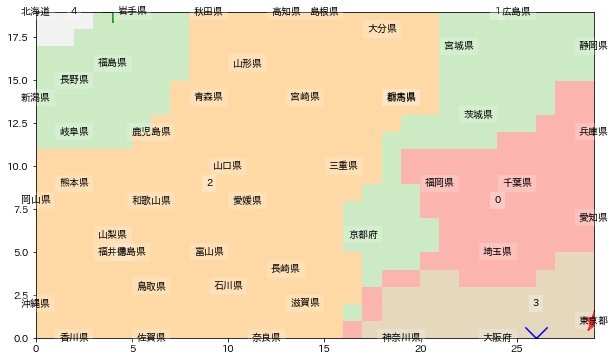

In [ ]:
newyork = sc.transform([[19541453,1413,19541453/1413]]) # ニューヨークのデータ
ny,nx = get_winner(W,newyork) # ニューヨークのデータに反応するニューロン位置
hongkong = sc.transform([[7392000,1106,7392000/1106]]) # 香港のデータ
hoy,hox = get_winner(W,hongkong) # 香港のデータに反応するニューロン位置
hawaii = sc.transform([[1428557,16634,1428557/16634]]) # ハワイのデータ
hwy,hwx = get_winner(W,hawaii) # ハワイのデータに反応するニューロン位置

labelimage, centers = kmeans(W,5,100)
somcenters = [get_winner(W,c) for c in centers]
# plt.rcParams['font.family'] = 'HGMaruGothicMPRO'　# ← Windows の場合この行の'# 'を削除
fig = plt.figure(figsize=(10,6))
plotBoundary(labelimage, somcenters)
writePref(W,pref,stdX,dataindex)
plt.scatter(nx,ny,s=500,marker='*',color='red') # ニューヨークは☆印
plt.scatter(hox,hoy,s=500,marker='x',color='blue') # 香港はX印
plt.scatter(hwx,hwy,s=500,marker='+',color='green') # ハワイは＋印

この実験により、
1. ニューヨーク州は日本で言えば東京都と似た人口、面積をもつ
2. 香港は日本で言えば東京都、大阪府、神奈川県と、人口、面積において類似しており、大阪府に近い。
3. ハワイは人口や面積、人口密度という観点で見れば、日本の東北地方に近い。

おまけ、としたが、これがSOMの本来の使い方の一つである。

# 付録　使用したデータ

In [ ]:
with open("jinkoSJ.csv", encoding="cp932") as f:
    print(f.read())

都道府県,人口,面積,人口密度
東京都,13636222,2191,6223.74
神奈川県,9145572,2415.92,3785.54
大阪府,8837812,1905.14,4638.93
愛知県,7507691,5172.9,1451.35
埼玉県,7288081,3797.75,1919.05
千葉県,6240408,5157.64,1209.93
兵庫県,5520575,8400.93,657.14
北海道,5352306,78420.77,68.25
福岡県,5106707,4986.4,1024.13
静岡県,3686945,7777.43,474.06
茨城県,2907262,6097.12,476.83
広島県,2838494,8479.47,334.75
京都府,2605731,4612.19,564.97
宮城県,2329431,7282.22,319.88
新潟県,2285856,12584.18,181.65
長野県,2087997,13561.56,153.96
岐阜県,2022785,10621.29,190.45
栃木県,1968425,6408.09,307.18
群馬県,1966381,6362.28,309.07
岡山県,1915401,7114.47,269.23
福島県,1900106,13783.74,137.85
三重県,1807611,5774.41,313.04
熊本県,1774538,7409.44,239.5
鹿児島県,1637073,9186.99,178.19
沖縄県,1439913,2281.14,631.23
滋賀県,1413079,4017.38,351.74
山口県,1393904,6112.34,228.05
愛媛県,1374881,5676.19,242.22
長崎県,1366514,4132.2,330.7
奈良県,1356950,3690.94,367.64
青森県,1293619,9645.56,134.12
岩手県,1268083,15275.01,83.02
大分県,1159634,6340.74,182.89
石川県,1150818,4186.09,274.91
山形県,1113029,9323.15,119.38
宮崎県,1095959,7735.31,141.68
富山県,10

In [ ]:
with open("kendata.csv", encoding="utf-8") as f:
    print(f.read())

﻿都道府県,人口,面積,人口密度,外国人,国籍不詳率,公務員,産業動物,小動物診療
愛知県,7507691 ,5173 ,1451 ,160228 ,0.0103 ,1671 ,395 ,92 
愛媛県,1374881 ,5676 ,242 ,7828 ,0.0058 ,397 ,123 ,34 
茨城県,2907262 ,6097 ,477 ,40477 ,0.0022 ,1145 ,216 ,124 
岡山県,1915401 ,7114 ,269 ,18476 ,0.0074 ,596 ,157 ,82 
沖縄県,1439913 ,2281 ,631 ,7651 ,0.0057 ,450 ,177 ,58 
岩手県,1268083 ,15275 ,83 ,5184 ,0.0019 ,628 ,137 ,162 
岐阜県,2022785 ,10621 ,190 ,36879 ,0.0032 ,664 ,215 ,36 
宮崎県,1095959 ,7735 ,142 ,3802 ,0.0034 ,652 ,226 ,209 
宮城県,2329431 ,7282 ,320 ,12367 ,0.0043 ,653 ,199 ,125 
京都府,2605731 ,4612 ,565 ,41855 ,0.0139 ,649 ,151 ,19 
熊本県,1774538 ,7409 ,240 ,7624 ,0.0062 ,655 ,187 ,126 
群馬県,1966381 ,6362 ,309 ,35458 ,0.0042 ,647 ,186 ,107 
広島県,2838494 ,8479 ,335 ,31882 ,0.0118 ,717 ,205 ,63 
香川県,972156 ,1877 ,518 ,6858 ,0.0079 ,343 ,104 ,29 
高知県,720907 ,7104 ,101 ,3172 ,0.0042 ,259 ,91 ,19 
佐賀県,828388 ,2441 ,339 ,3594 ,0.0027 ,255 ,98 ,34 
埼玉県,7288081 ,3798 ,1919 ,88734 ,0.0071 ,1967 ,345 ,73 
三重県,1807611 ,5774 ,313 ,32825 ,0.0051 ,455 ,149 ,39 
山形県,

# 日本語フォントに関する補足説明

旧来、Windowsでは日本語フォントとして 「シフト JIS コード ＝ cp932」が用いられてきた。最近は世界共通のマルチバイトフォントの仕様である  Unicode にシフトしている。Macはほぼ完全にシフトしているし、python 言語も Unicode がデフォルトである。Windowsも Unicode が使われているが、日本語オフィス環境ではいまだ Shift JIS が用いられており、Excelでも、指定しなければシフトJISコードが使われる。

このプログラムでは、jinkoSJ.csv には cp932 (シフトJISコードのコード名)、kendata.csv では utf-8（Unicode)を用いた。

Windows版日本語Excelは特に指定せずに csv 形式で保存するといまだシフトJISコードが用いられる（時代遅れである）。Unicode形式で保存したければ、ファイルの種類として 「**CSV UTF-8 (コンマ区切り）**」を選べばよい。

上のセルでは説明上、明示的に 

``` encoding =utf-8 ``` 

と指定したが、python は utf-8 がデフォルトであるので、utf-8 の場合は無指定でよい。